# stitch_by_sat

For each day's satellite acquisitions, grab all the tiles for each satellite and stitch them together into a "satellite chunk". Remove those satellite chunks that cover less than a third of the glacier (evaluated using a glacier outline shapefile).

In [139]:
import rasterio as rio
from rasterio.mask import mask
import cv2
import fiona
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d
import glob 
import pandas as pd
from shapely.geometry import mapping
import geopandas as gpd

In [ ]:
import sys
args = sys.argv
basepath = args[1] # image path
aoi_shp = args[2] # aoi shapefile path

inputs: -img_path -glacier_shpfile_path

In [149]:
# basepath = '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/' # path to grid standardized images

In [141]:
# path to study area shapefile
# aoi_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/BoxTurner_UTM_07.shp'
aoi_gdf = gpd.read_file(aoi_shp)
aoi = aoi_gdf.geometry.values
print(aoi[0])

POLYGON ((546082.8268453347 6669426.551069965, 559359.2437101691 6682895.37977342, 587703.2183131702 6654956.319093321, 574426.8014483359 6641487.490389868, 546082.8268453347 6669426.551069965))


In [150]:
# # path to glacier shapefile
# glacier_shp = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/main_ice_outline.shp'
# glacier_gdf = gpd.read_file(glacier_shp)
# glacier = glacier_gdf.geometry.values
# glacier[0]

# Coregister and stitch all Planet tiles for each image date

In [143]:
# grab all satellite IDs and dates of imagery
filelist = os.listdir(basepath); filelist.sort()
dates = []; IDs = []; files = []
no_tiles  = 0
for file in filelist:
    if file.startswith('2') and file.endswith('.tif'):
        date = file.split('_')[0] # grab the date
        sID = file.split('_')[-7] # grab the satellite ID (4 digit code)
        dates.append(date); IDs.append(sID); files.append(file) # append to list
        no_tiles+=1
sorted_dates = list(set(list(zip(dates, IDs)))) # set of the zipped date and ID
sorted_dates.sort() # sorted
satdate_df = pd.DataFrame(sorted_dates, columns=['date','sat_ID'])
satdate_df.head()

,date,sat_ID
0,20200903,1064
1,20200903,2206
2,20200904,2278
3,20200905,1010
4,20200905,106b


In [144]:
# Grab the first Planet tile for reference CRS and Transform
reftile = rio.open(basepath+filelist[3])
print(reftile.crs)
print(reftile.transform)
print(reftile.shape)

EPSG:32607
| 4.98, 0.00, 546080.48|
| 0.00,-4.98, 6682898.32|
| 0.00, 0.00, 1.00|
(8317, 8360)


TILES FOR 20200903 1064
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200903_204744_72_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif']


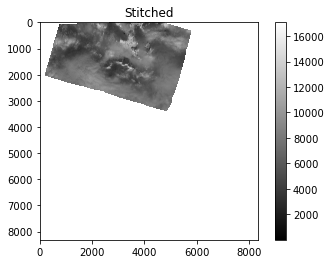

TILES FOR 20200903 2206
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200903_194841_15_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200903_194845_57_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200903_194845_57_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif


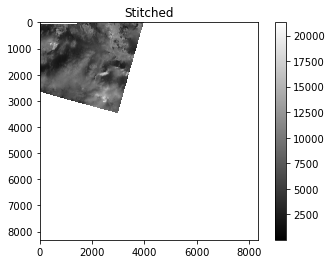

TILES FOR 20200904 2278
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200904_194836_46_2278_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200904_194838_86_2278_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200904_194841_25_2278_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200904_194843_64_2278_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


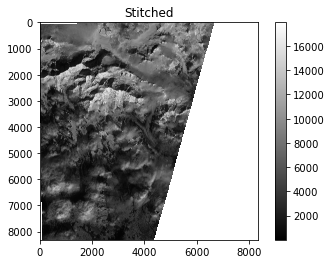

TILES FOR 20200905 1010
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201602_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201603_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201604_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201605_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201602_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_201605_1010_3B_AnalyticMS_SR_harmonized_clip_5m.tif


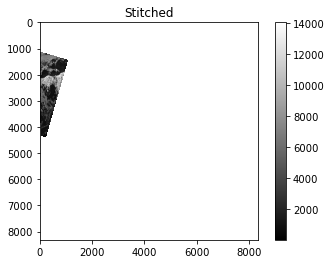

TILES FOR 20200905 106b
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_191452_27_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']


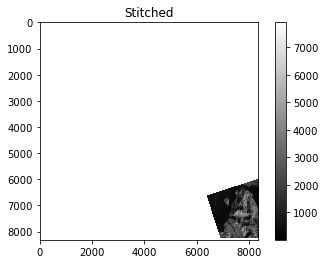

TILES FOR 20200905 2271
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200905_195053_63_2271_3B_AnalyticMS_SR_harmonized_clip_5m.tif']


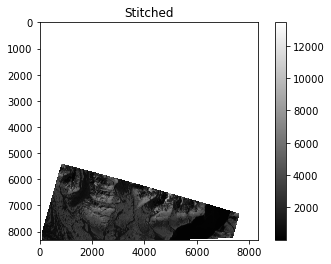

TILES FOR 20200906 0f49
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170012_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170013_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170014_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170015_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170016_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170017_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170017_1_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_g

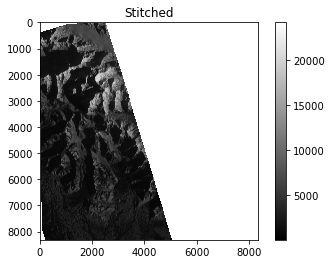

TILES FOR 20200906 100d
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170400_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170401_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170402_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170403_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170404_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170405_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200906_170406_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

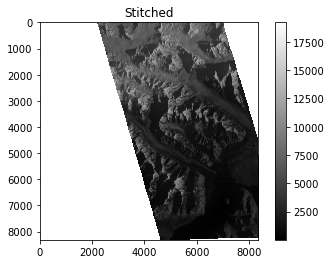

TILES FOR 20200909 106b
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200909_191513_24_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']


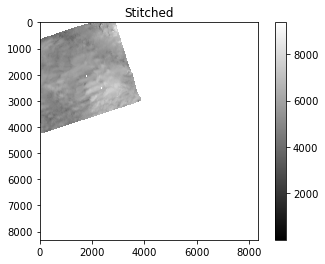

TILES FOR 20200910 1049
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165944_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165945_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165946_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165947_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165947_1_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165948_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_165949_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_g

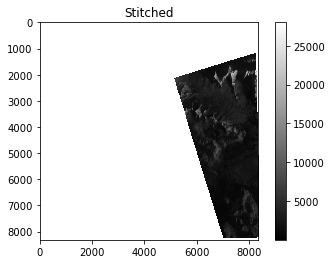

TILES FOR 20200910 106c
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191712_87_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191714_88_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191716_89_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191718_91_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191720_92_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_191712_87_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


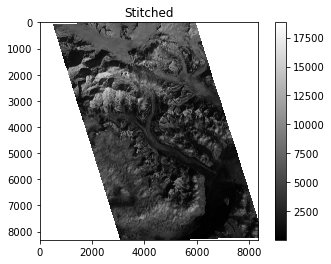

TILES FOR 20200910 2263
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_195446_65_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_195449_02_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_195451_40_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_195453_78_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200910_195446_65_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


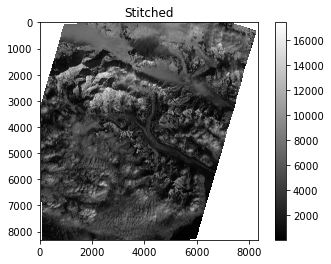

TILES FOR 20200911 100d
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_165959_1_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170000_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170001_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170002_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170003_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170004_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_170005_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_g

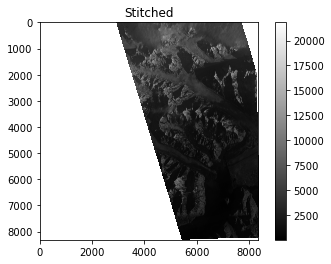

TILES FOR 20200911 2212
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_194626_56_2212_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_194628_78_2212_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_194630_99_2212_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_194633_20_2212_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200911_194626_56_2212_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


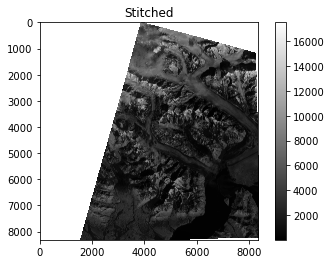

TILES FOR 20200912 0f46
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165911_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165912_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165913_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165914_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165911_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165912_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_165913_0f46_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PS

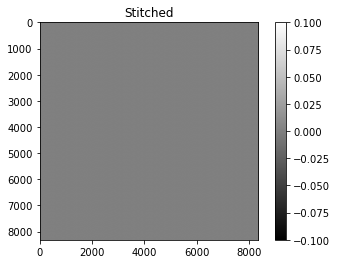

TILES FOR 20200912 1008
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201633_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201634_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201635_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201636_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201638_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201639_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_201640_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

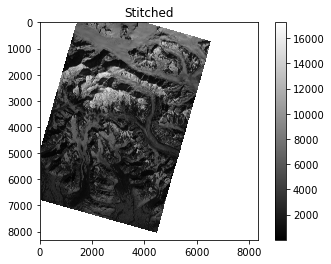

TILES FOR 20200912 1065
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_192128_64_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_192130_69_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_192132_74_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_192134_80_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_192134_80_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif


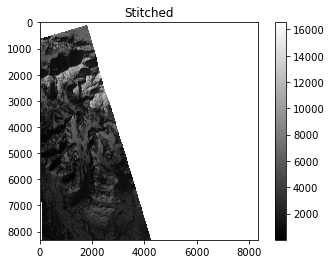

TILES FOR 20200912 2206
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_194934_20_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_194936_41_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_194938_62_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_194940_83_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200912_194934_20_2206_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


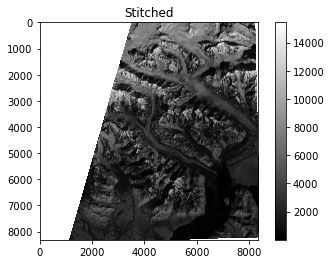

TILES FOR 20200913 0f22
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201216_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201217_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201218_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201220_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201221_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201222_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_201216_0f22_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/st

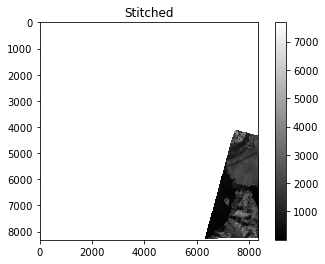

TILES FOR 20200913 1050
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165920_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165921_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165922_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165923_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165924_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165925_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_165926_1050_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

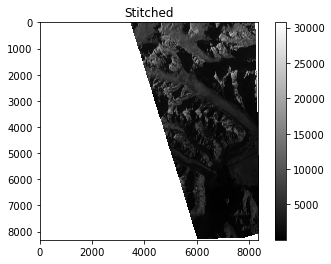

TILES FOR 20200913 1058
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_204609_21_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_204610_72_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_204612_23_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
Previous tile is larger.


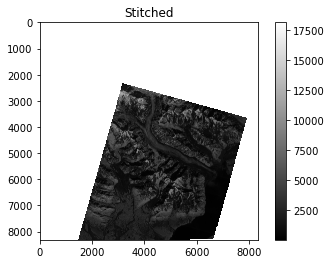

TILES FOR 20200913 2304
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_195502_84_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200913_195505_24_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.


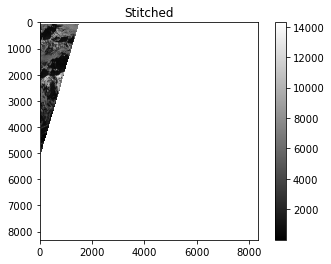

TILES FOR 20200914 0f3c
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165742_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165743_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165744_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165745_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165742_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165743_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_165744_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PS

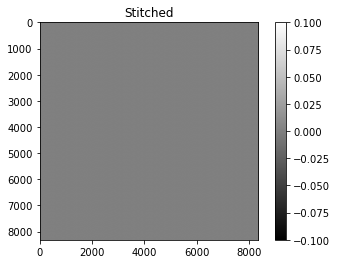

TILES FOR 20200914 1005
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_200847_1005_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_200847_1005_3B_AnalyticMS_SR_harmonized_clip_5m.tif


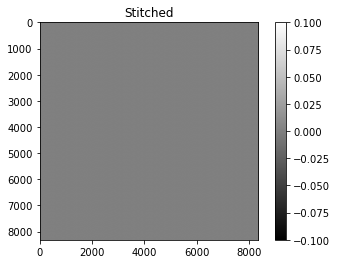

TILES FOR 20200914 1025
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201028_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201029_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201030_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201031_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201032_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201033_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_201034_1025_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

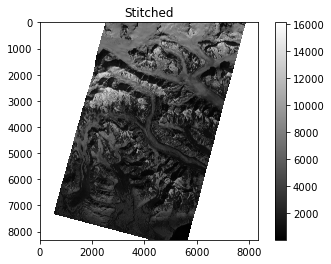

TILES FOR 20200914 1054
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170222_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170223_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170224_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170225_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170226_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170227_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200914_170228_1054_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

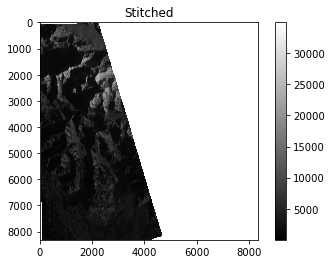

TILES FOR 20200915 1048
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165919_1_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165920_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165921_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165922_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165923_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165924_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165925_1048_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_g

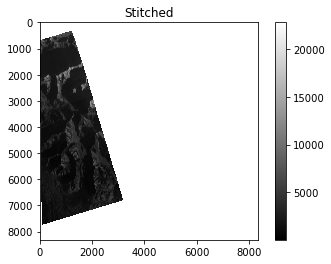

TILES FOR 20200915 1049
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165546_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165547_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165548_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165549_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165550_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165546_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_165547_1049_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScen

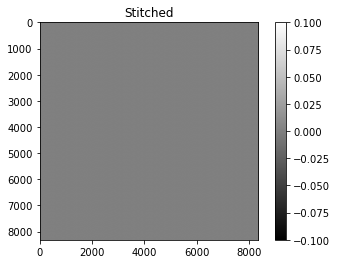

TILES FOR 20200915 1061
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204849_86_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204851_86_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204853_87_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204855_88_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204857_88_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_204849_86_1061_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


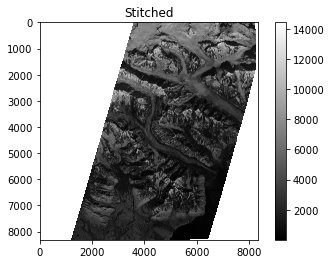

TILES FOR 20200915 2263
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_195804_69_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_195807_07_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_195809_44_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200915_195809_44_2263_3B_AnalyticMS_SR_harmonized_clip_5m.tif


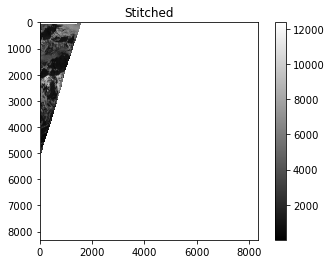

TILES FOR 20200916 0f21
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170201_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170202_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170203_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170204_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170205_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170206_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_170207_0f21_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standa

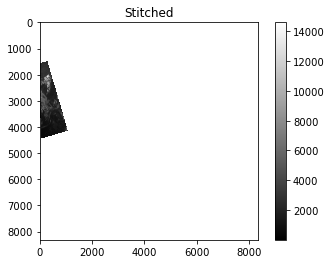

TILES FOR 20200916 100d
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165551_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165552_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165553_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165554_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165555_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165556_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_165557_100d_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_gri

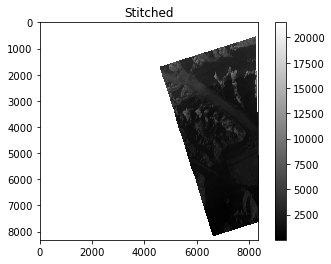

TILES FOR 20200916 106e
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_191246_80_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_191248_85_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_191250_90_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_191252_95_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_191252_95_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif


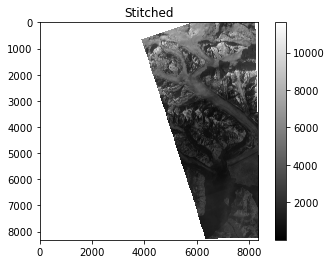

TILES FOR 20200916 2231
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_194804_69_2231_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_194807_04_2231_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200916_194809_39_2231_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


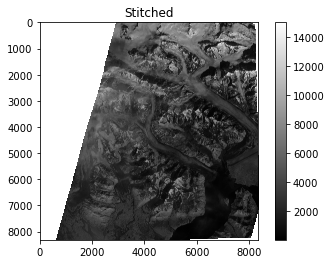

TILES FOR 20200918 1066
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_204436_22_1066_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_204440_72_1066_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_204440_72_1066_3B_AnalyticMS_SR_harmonized_clip_5m.tif


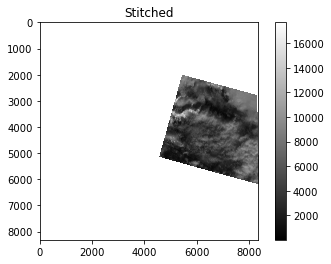

TILES FOR 20200918 106c
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_191741_03_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_191745_08_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_191747_10_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_191747_10_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif


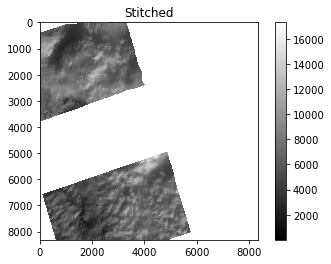

TILES FOR 20200918 2412
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_204237_88_2412_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200918_204240_23_2412_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Previous tile is larger.


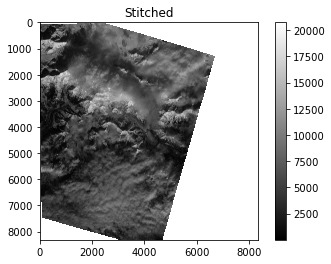

TILES FOR 20200919 1040
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200919_201127_1040_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200919_201128_1040_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200919_201129_1040_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200919_201130_1040_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200919_201127_1040_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


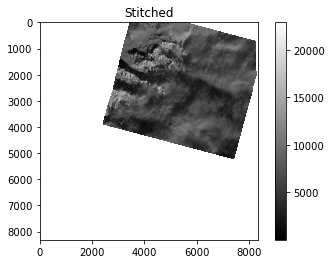

TILES FOR 20200920 104b
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165854_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165855_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165856_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165857_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165854_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Previous tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_165857_104b_3B_AnalyticMS_SR_harmonized_clip_5m.tif


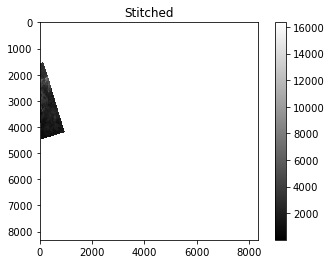

TILES FOR 20200920 1058
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_204813_09_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200920_204813_09_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif


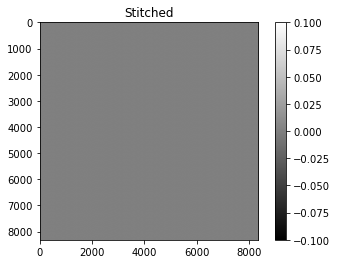

TILES FOR 20200924 0f44
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_165701_0f44_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_165701_0f44_3B_AnalyticMS_SR_harmonized_clip_5m.tif


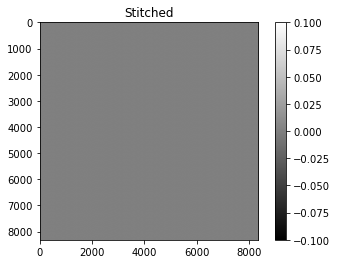

TILES FOR 20200924 1014
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_201121_1014_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_201122_1014_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_201124_1014_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
Current tile is larger.
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200924_201124_1014_3B_AnalyticMS_SR_harmonized_clip_5m.tif


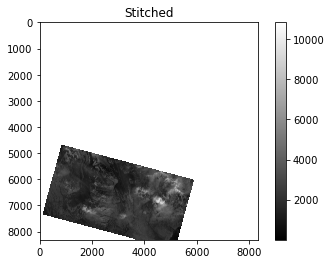

TILES FOR 20200925 104a
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165809_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165810_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165811_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165812_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165812_1_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165813_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_165809_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/

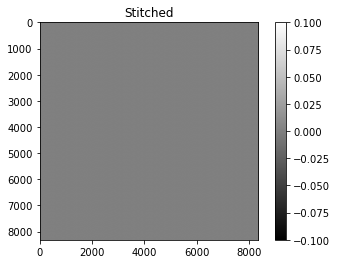

TILES FOR 20200925 106b
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_191551_46_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_191553_51_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_191555_56_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_191551_46_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Previous tile is larger.


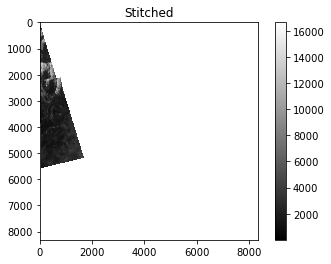

TILES FOR 20200925 2278
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200925_194749_51_2278_3B_AnalyticMS_SR_harmonized_clip_5m.tif']


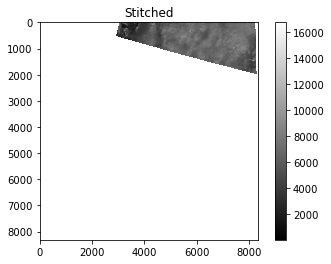

TILES FOR 20200926 105a
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200926_204931_43_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200926_204932_96_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200926_204934_50_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200926_204936_04_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200926_204931_43_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.
Previous tile is larger.


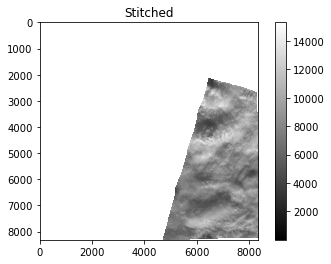

TILES FOR 20200929 2304
['/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200929_194734_26_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200929_194736_66_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif', '/Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200929_194739_05_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif']
remove /Volumes/SURGE_DISK/PS_downloads_SK/2020-09/PSScene/standard_grid/20200929_194734_26_2304_3B_AnalyticMS_SR_harmonized_clip_5m.tif
Current tile is larger.


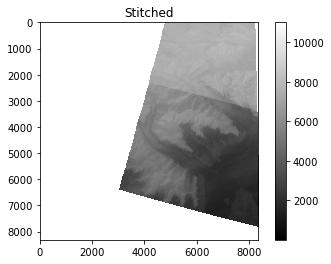

In [145]:
binary_thresh = 1
for idx, row in satdate_df.iterrows():
    date = row.date
    ID = row.sat_ID
    print('TILES FOR', date, ID)
    
    # Grab the Planet tiles corresponding to each unique date
    tiles = glob.glob(basepath+'/'+date+'*'+ID+'*clip_5m.tif') # grab all file paths for that date
    tiles.sort()
    print(tiles)
    
    # initialize empty arrays
    overlap_total = np.zeros(reftile.shape);
    sr_stitched = np.zeros(reftile.shape) # start with empty stitched product
    t = 0 # tile count
    
    for tile in tiles:
        # open image tile, determine overlap with AOI, remove if none
        reader = rio.open(tile); sr = reader.read(1) # load the tile
        try:
            out_image, out_transform = mask(reader, [mapping(aoi[0])], crop=True)
            crop_array = out_image[0,:,:]
            # if no overlapping pixels, remove
#             if np.count_nonzero(~np.isnan(crop_array)) == 0:
            if np.count_nonzero(crop_array[~np.isnan(crop_array)]) == 0:
                print('remove '+tile)
                os.remove(tile)
                continue
        except Exception:
            # if it fails to crop, then remove
#             print('remove '+tile)
            continue
        
        # if there is overlap, continue with processing
        sr[sr == 0] = np.NaN # remove black background, replace with Nans
        sr_data = sr.copy() # make a copy of the data before making the data binary
        sr[sr>0.0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_total = overlap_total+sr # add new overlap to overlap total
        
        if t==0: # just add the first one
            sr_stitched = np.nansum([sr_data, sr_stitched],0) # add them to the stitched product
        else:
            # for all subsequent, find the overlapping area:
            overlap_band = ma.masked_not_equal(overlap_total, 2) # identify non-overlapping area (not 2)
            overlap_band_mask = ma.getmaskarray(overlap_band)
            
            # identify which tile is larger
            if tilesize > prev_tilesize:
                print('Current tile is larger.')
                larger_tile = sr_data; smaller_tile = sr_stitched # assign the tiles
            elif tilesize < prev_tilesize:
                print('Previous tile is larger.')
                larger_tile = sr_stitched; smaller_tile = sr_data # assign the tiles
            else: # equal sizes
                print('Tiles are the same size.')
                larger_tile = sr_data; smaller_tile = sr_stitched # use current tile to coregister
                    
            # identify which overlapping tile is larger or smaller
            overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
            overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
            overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
            overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data

            # remove overlap area from smaller tile and add to total
            smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile) 
            masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
            sr_stitched = np.nansum([masked_smaller_tile_coreg, larger_tile],0) 
            
            overlap_total[overlap_total > 1] = 1 # reset overlap total values to be 1
            # Store tile info for the next round of comparison
            prev_overlap = overlap_band.size # amount of pixels overlapping
        prev_tilesize = np.count_nonzero(sr_stitched) # previous tile size (pixels w/ data)
        sr_prev = sr_data
        sr_stitched[sr_stitched == 0]=np.NaN # fill black pixels with NaNs
        t += 1 # increment tile count
        
#     # Plot final stitched image
#     fig = plt.figure(); im = plt.imshow(sr_stitched, cmap='gray'); plt.title('Stitched'); 
#     fig.colorbar(im); plt.show()
    
    # Export stitched image
    outfilename = 'PS_'+date+'_'+ID+'.tif'
    if not os.path.exists(basepath+"stitched_by_sat/"):
        os.mkdir(basepath+"stitched_by_sat/")
    with rio.open(basepath+"stitched_by_sat/"+outfilename,'w',
                      driver='GTiff',
                      height=sr_stitched.shape[0], # new shape
                      width=sr_stitched.shape[1], # new shape
                      dtype=sr_stitched.dtype, # data type
                      count=1,
                      crs=reftile.crs, # the EPSG from the original DEM
                      transform=reftile.transform) as dst:
            dst.write(sr_stitched, 1)
            
    del overlap_total; del sr_stitched # clear variables
    

# Delete those empty images

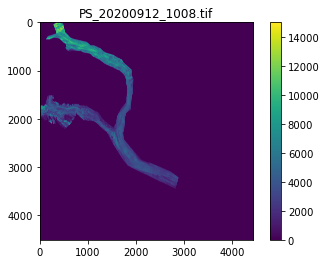

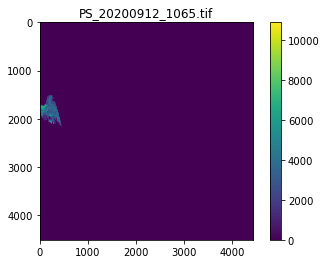

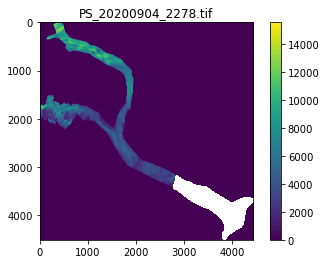

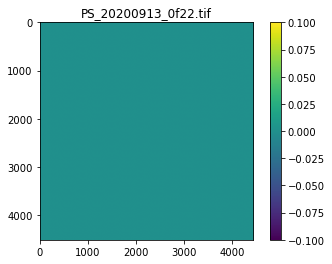

remove empty tile PS_20200913_0f22.tif


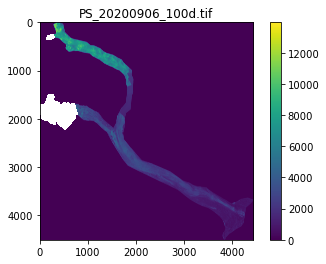

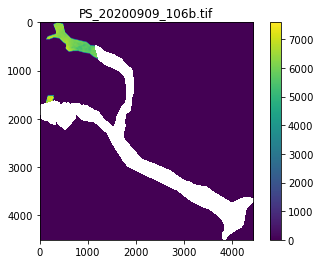

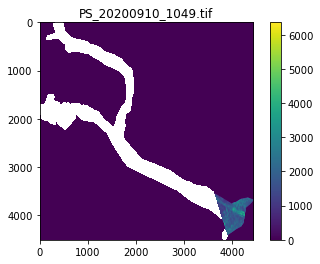

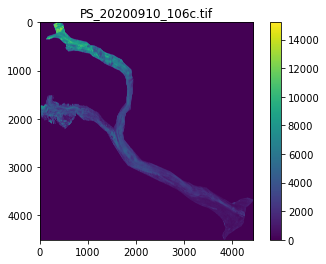

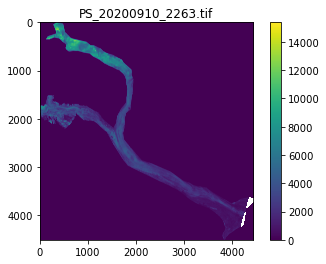

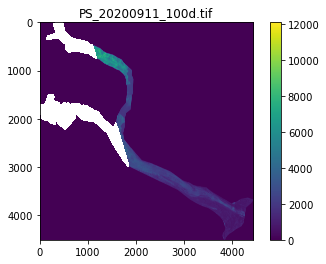

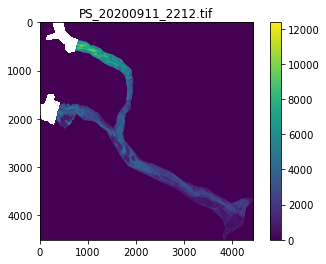

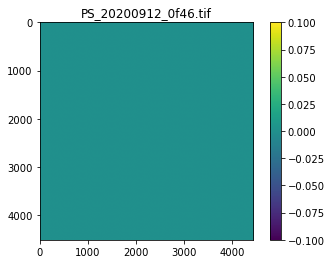

remove empty tile PS_20200912_0f46.tif


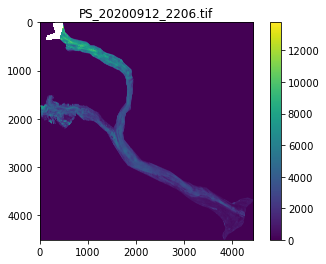

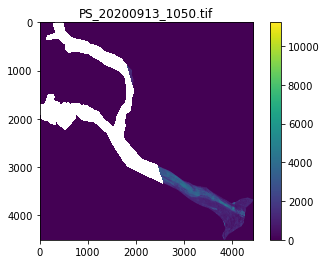

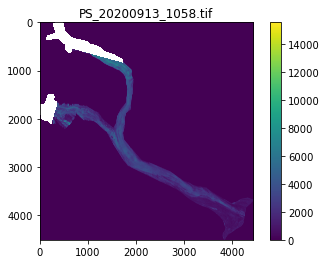

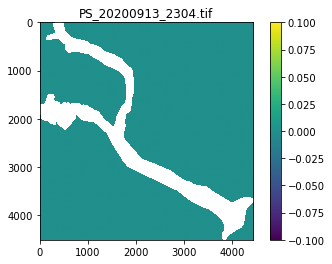

remove empty tile PS_20200913_2304.tif


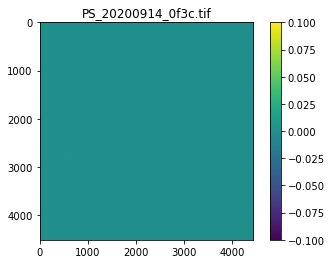

remove empty tile PS_20200914_0f3c.tif


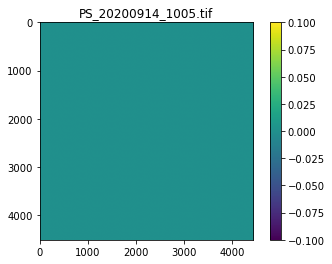

remove empty tile PS_20200914_1005.tif


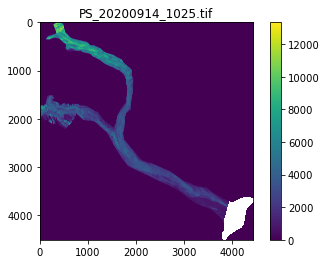

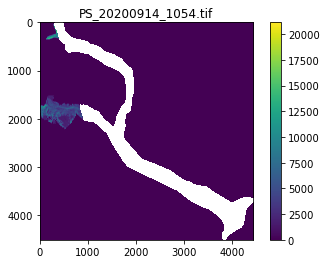

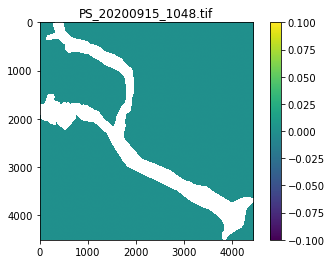

remove empty tile PS_20200915_1048.tif


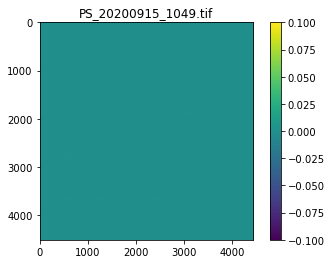

remove empty tile PS_20200915_1049.tif


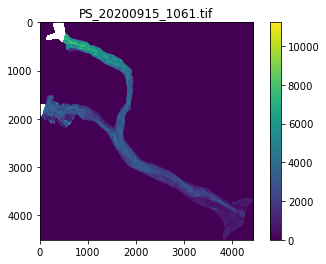

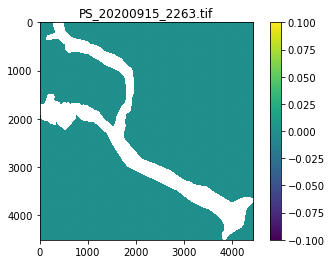

remove empty tile PS_20200915_2263.tif


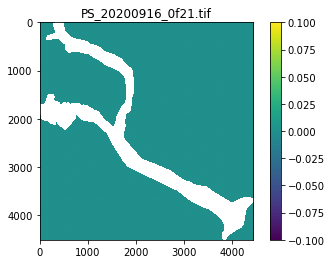

remove empty tile PS_20200916_0f21.tif


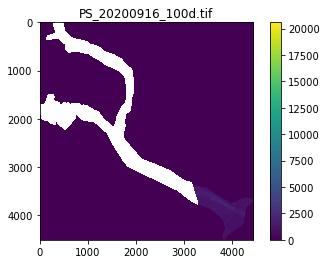

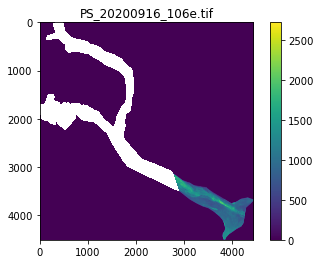

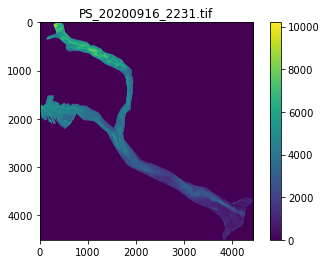

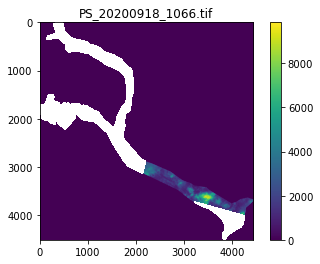

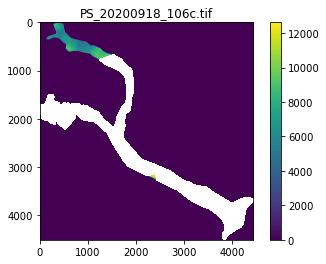

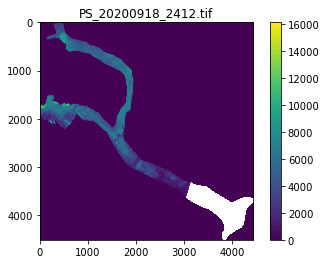

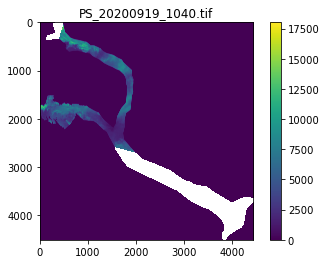

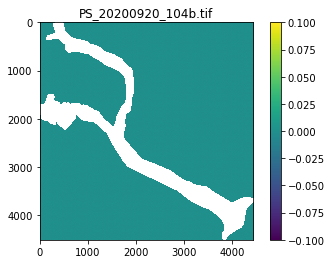

remove empty tile PS_20200920_104b.tif


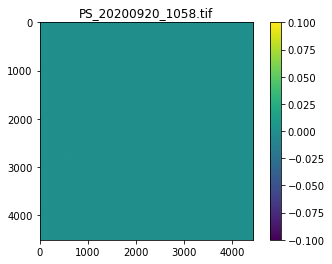

remove empty tile PS_20200920_1058.tif


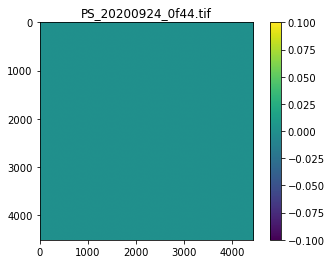

remove empty tile PS_20200924_0f44.tif


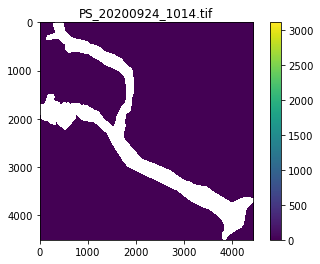

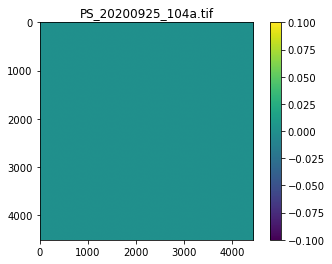

remove empty tile PS_20200925_104a.tif


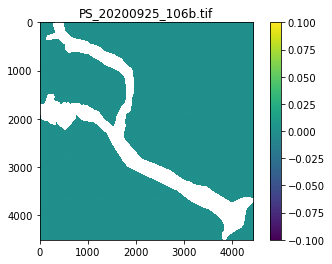

remove empty tile PS_20200925_106b.tif


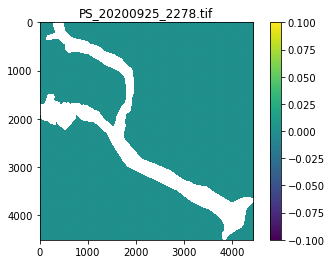

remove empty tile PS_20200925_2278.tif


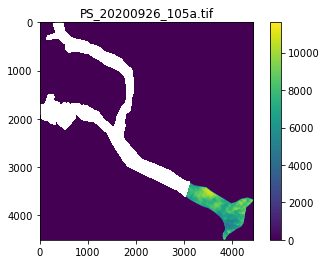

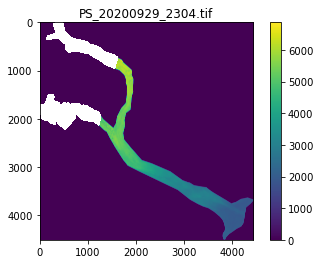

In [148]:
for newfile in os.listdir(basepath+"stitched_by_sat/"):
    if newfile.startswith('PS') and newfile.endswith('.tif'):
        reader = rio.open(basepath+"stitched_by_sat/"+newfile)
        try:
            # crop to glacier outline
            out_image, out_transform = mask(reader, [mapping(glacier[0])], crop=True)
            crop_array = out_image[0,:,:]
            
#             # plot
#             plt.imshow(crop_array); plt.colorbar(); plt.title(newfile)
#             plt.show()
            
            # count coverage
            coverage = np.count_nonzero(crop_array[~np.isnan(crop_array)])
            
            # If image is empty, remove:
            if np.nanmax(crop_array) == 0:
                print('remove empty tile',newfile)
                os.remove(basepath+"stitched_by_sat/"+newfile)
                
#             # set all nonzeros to 1 to count glacier pixels
#             crop_array[crop_array != 0] = 1
#             glacier_pixels = np.count_nonzero(crop_array)
            
#             # if overlapping pixels is less than 25% of the total glacier pixels 
#             if coverage/glacier_pixels < 0.33:
#                 print('Coverage is',str(int(coverage/glacier_pixels*100)),'% remove '+newfile)
#                 os.remove(basepath+"stitched_by_sat/"+newfile)
        except Exception:
            # if it fails to crop, then remove
#             print('remove '+tile)
            continue